In [1]:
import os
seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
experiment = 'Full Cycle CNN Images Experiment'

In [2]:
import requests
import lxml
import datetime as dt
import pandas as pd
import pandas_datareader.data as web
import numpy as np
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.utils import compute_class_weight
import tensorflow as tf
from pil import Image
from sklearn import preprocessing
import tensorflow_addons as tfa
import glob
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import MinMaxScaler
import math

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
# gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.333)
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [4]:
np.random.seed(seed)
tf.random.set_seed(seed)

session_conf = tf.compat.v1.ConfigProto(
    intra_op_parallelism_threads=1, 
    inter_op_parallelism_threads=1
)
sess = tf.compat.v1.Session(
    graph=tf.compat.v1.get_default_graph(), 
    config=session_conf
)
tf.compat.v1.keras.backend.set_session(sess)

## Prepare Test Data

In [5]:
test_sets = ['accumulation phase data','mark up phase data','distribution phase data','mark down phase data','bull phase data','bear phase data','full cycle data']
test_data = {}

for name in test_sets:

    df = pd.read_csv("{}/test_data.csv".format(name))
    df.set_index('Date', inplace=True)
    print(df.head())
    
    willr_data = []
    price_data = []
    ema_data = []
    obv_data = []
    labels = []
    data_15_price = []
    data_15_willr = []
    data_15_ema = []
    data_15_obv = []
    count = 0

    for i in df.values:
        if count == 14:
            data_15_price.append([i[0]])
            data_15_ema.append([i[1]])
            data_15_willr.append([i[2]])
            data_15_obv.append([i[3]])
            min_max_scaler = preprocessing.MinMaxScaler()
            data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
            data_15_ema_arr = min_max_scaler.fit_transform(data_15_ema)
            data_15_willr_arr = min_max_scaler.fit_transform(data_15_willr)
            data_15_obv_arr = min_max_scaler.fit_transform(data_15_obv)
            price_data.append(data_15_price_arr)
            willr_data.append(data_15_willr_arr)
            ema_data.append(data_15_ema_arr)
            obv_data.append(data_15_obv_arr)
            labels.append(i[-1])
            data_15_price = data_15_price[1:]
            data_15_willr = data_15_willr[1:]
            data_15_obv = data_15_obv[1:]
            data_15_ema = data_15_ema[1:]

        else:
            data_15_price.append([i[0]])
            data_15_ema.append([i[1]])
            data_15_willr.append([i[2]])
            data_15_obv.append([i[3]])
            count += 1

    willr_data = np.array(willr_data)
    price_data = np.array(price_data)
    ema_data = np.array(ema_data)
    obv_data = np.array(obv_data)
    
    sequential_data = []
    
    for i in range(0,len(willr_data)):
        j = willr_data[i]
        k = price_data[i]
        l = ema_data[i]
        m = obv_data[i]
        fig, ax = plt.subplots()
        fig.set_size_inches((5,5))

        ax.plot(k)
        ax.plot(j)
        ax.plot(l)
        ax.plot(m)

        ax.axis('off')

        fig.add_axes(ax)
        fig.canvas.draw()

        # this rasterized the figure
        X = np.array(fig.canvas.renderer._renderer)
        X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
        X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
        sequential_data.append(X)
        plt.close()
        
    X = sequential_data
    y = labels

    X  = np.array(X).reshape(-1, 64, 64, 1)
    X = X/255
    y = np.array(y)
    
    y = to_categorical(y, 3)
    
    test_data['{}_X'.format(name)] = X
    test_data['{}_y'.format(name)] = y

            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2004-06-14    93.010002  92.918784 -32.009897  48922600.0     2.0
2004-06-15    91.529999  92.705124 -68.734488  45879300.0     2.0
2004-06-16    90.209999  92.321259 -94.676024  40369000.0     2.0
2004-06-17    89.980003  91.961066 -87.983635  36219100.0     2.0
2004-06-18    89.339996  91.557824 -85.961924  32718400.0     2.0
            previous_1d      EMA_12   willr_14       OBV_7  labels
Date                                                              
2020-01-22   115.589996  116.459043 -80.074504 -17684500.0     2.0
2020-01-23   116.099998  116.403805 -70.577262 -12758400.0     2.0
2020-01-24   115.809998  116.312450 -69.789236 -17063500.0     2.0
2020-01-27   114.370003  116.013612 -94.416205 -21446900.0     2.0
2020-01-28   115.860001  115.989979 -34.297465 -14428500.0     2.0
            previous_1d      EMA_12   willr_14        OBV_7  labels
D

## Train Accumulation Phase Stock Data

In [6]:
def pred_acc(actual, predictions, logger):

    hold = 0
    sell = 0
    buy = 0
    pred_hold = 0
    pred_sell = 0
    pred_buy = 0
    buy_buy = 0
    buy_sell = 0
    buy_hold = 0
    sell_buy = 0
    sell_sell = 0
    sell_hold = 0
    hold_buy = 0
    hold_sell = 0
    hold_hold = 0

    for i in range (0,len(actual)):
        if actual[i]==1 and predictions[i] == 1:
            buy_buy += 1
            buy += 1
            pred_buy += 1
        elif actual[i]==1 and predictions[i] == 0:
            buy_sell += 1
            buy += 1
            pred_sell += 1
        elif actual[i]==1 and predictions[i] == 2:
            buy_hold += 1
            buy += 1
            pred_hold += 1
        elif actual[i]==0 and predictions[i] == 1:
            sell_buy += 1
            sell += 1
            pred_buy += 1
        elif actual[i]==0 and predictions[i] == 0:
            sell_sell += 1
            sell += 1
            pred_sell += 1
        elif actual[i]==0 and predictions[i] == 2:
            sell_hold += 1
            sell += 1
            pred_hold += 1
        elif actual[i]==2 and predictions[i] == 1:
            hold_buy += 1
            hold += 1
            pred_buy += 1
        elif actual[i]==2 and predictions[i] == 0:
            hold_sell += 1
            hold += 1
            pred_sell += 1
        elif actual[i]==2 and predictions[i] == 2:
            hold_hold += 1
            hold += 1
            pred_hold += 1

    print("number of predictions: " + str(len(actual)))
    print("actual predicted buys: " + str(buy_buy) )
    print("actual buys but predicted sell: " + str(buy_sell) )
    print("actual buys but predicted hold: " + str(buy_hold))
    print("actual sells but predicted buy: " + str(sell_buy) )
    print("actual predicted sells: " + str(sell_sell))
    print("actual sells but predicted hold: " + str(sell_hold) )
    print("actual holds but predicted buy: " + str(hold_buy) )
    print("actual holds but predicted sell: " + str(hold_sell))
    print("actual predicted holds: " + str(hold_hold) )
    
    if pred_buy !=0:
        Percentage_buys_correct = 100*buy_buy/pred_buy
    else:
        Percentage_buys_correct = 0
        
    if pred_sell !=0:
        Percentage_sells_correct = 100*sell_sell/pred_sell
    else:
        Percentage_sells_correct = 0
        
    if pred_hold !=0:
        Percentage_holds_correct = 100*hold_hold/pred_hold
    else:
        Percentage_holds_correct = 0

    print("Percentage buys correct: " + str(Percentage_buys_correct) + "%")
    print("Percentage sells correct: " + str(Percentage_sells_correct) + "%")
    print("Percentage holds correct: " + str(Percentage_holds_correct) + "%")

    print("actual buys: " + str(buy))
    print("actual sells: " + str(sell))
    print("actual holds: " + str(hold))
    logger.append(Percentage_buys_correct) ; logger.append(Percentage_sells_correct) ; logger.append(Percentage_holds_correct)
    
    return logger


In [7]:
def correct_maxima_minima(predictions, price, logger):
    correct_maxima = 0 
    correct_minima = 0
    correct_hold = 0

    hold = 0
    buy = 0
    sell = 0

#     predictions = df['predictions'].values.tolist()
#     price = df['previous_1d'].values.tolist()

    for i in range(0,len(predictions)):
        if i < 4:
            prices = price[i:i+9]
            prices.sort(key = float)
#             if i == 0:
#                 print(prices)
            highest_1 = prices[-1]
            highest_2 = prices[-2]
            highest_3 = prices[-3]
            highest_4 = prices[-4]
            lowest_1 = prices[0]
            lowest_2 = prices[1]
            lowest_3 = prices[2]
            lowest_4 = prices[3]
            if predictions[i] == 0:
                sell += 1
                if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                    correct_maxima += 1
            elif predictions[i] == 1:
                buy += 1
                if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                    correct_minima += 1
            elif predictions[i] == 2:
                hold += 1
                if price[i] != lowest_1 and price[i] != highest_1:
                    correct_hold += 1

        else:
            prices = price[i:i+5]
            prices = prices + price[i-4:i] 
            prices.sort(key = float)
#             if i == 10:
#                 print(prices)
            highest_1 = prices[-1]
            highest_2 = prices[-2]
            highest_3 = prices[-3]
            highest_4 = prices[-4]
            lowest_1 = prices[0]
            lowest_2 = prices[1]
            lowest_3 = prices[2]
            lowest_4 = prices[3]
            if predictions[i] == 0:
                sell += 1
                if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                    correct_maxima += 1
            elif predictions[i] == 1:
                buy += 1
                if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                    correct_minima += 1
            elif predictions[i] == 2:
                hold += 1
                if price[i] != lowest_1 and price[i] != highest_1:
                    correct_hold += 1
                    
    if buy !=0:
        Percentage_buys_correct = 100*correct_minima/buy
    else:
        Percentage_buys_correct = 0
        
    if sell !=0:
        Percentage_sells_correct = 100*correct_maxima/sell
    else:
        Percentage_sells_correct = 0
        
    if hold !=0:
        Percentage_holds_correct = 100*correct_hold/hold
    else:
        Percentage_holds_correct = 0

    print("Percentage low buys correct: " + str(Percentage_buys_correct) + "%")
    print("Percentage high sells correct: " + str(Percentage_sells_correct) + "%")
    print("Percentage mid holds correct: " + str(Percentage_holds_correct) + "%")
    logger.append(Percentage_buys_correct) ; logger.append(Percentage_sells_correct) ; logger.append(Percentage_holds_correct)
    
    return logger

In [8]:
def profit(predictions, price, logger):
    
    price = np.array([price]).reshape(-1, 1)
    min_max_scaler = preprocessing.MinMaxScaler()
    price = min_max_scaler.fit_transform(price)
    price = price.flatten().tolist()
    price = [x + 0.01 for x in price]
    
#     avg_price = sum(price) / len(price)
#     avg_price = int(avg_price)
#     print("Avg price of stocks: " + str(avg_price))
    
#     tens = 1
#     while avg_price >= 10:
#         avg_price /= 10
#         tens += 1
    
    
#     capital = 100*pow(10,tens-1)
    capital = 100
    print("Capital: " + str(capital))
    shares = 0

    previously_buy = False
    previously_sell = False
    prev_buy_price = 0
    bought_once = False


#     predictions = df['predictions'].values.tolist()
#     price = df['previous_1d'].values.tolist()

    for i in range(0,len(predictions)):

#         if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 5 and shares!=0:
#             capital += 0.99725 * (shares*price[i])
#             shares = 0
#             print("Stop Loss Activated!\n")
#             print("Share price: $" + str(price[i]))
#             print("Shares owned at the moment: " + str(shares))
#             print("Cash capital at the moment: $" + str(capital))
#             print("\n")
#             previously_buy = False
#             previously_sell = True

        if predictions[i] == 1 and previously_buy != True:
            shares = math.floor(capital / (price[i]*1.00275))
            capital = capital - shares*price[i]*1.00275
            print("Share price: $" + str(price[i]))
            print("Shares owned at the moment: " + str(shares))
            print("Cash capital at the moment: $" + str(capital))
            print("\n")
            prev_buy_price = price[i]*1.00275
            bought_once = True
            previously_buy = True
            previously_sell = False

        elif predictions[i] == 0 and previously_sell != True and shares!=0: #and (price[i]/prev_buy_price-1)*100 >= 2
            capital += 0.99725 * (shares*price[i])
            shares = 0
            print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
            print("Share price: $" + str(price[i]))
            print("Shares owned at the moment: " + str(shares))
            print("Cash capital at the moment: $" + str(capital))
            print("\n")
            previously_buy = False
            previously_sell = True

    if shares!=0:
        capital += 0.99725 * (shares*price[i])

    print('\n')
    print("Capital at the end of test period: $" +str(capital))
    print("profit gained: " + str(((capital- 100 )/ 100) * 100 ) + '%') 
    logger.append(((capital- 100 )/ 100) * 100)
    
    capital = 100
    shares = 0

    shares = math.floor(capital / (price[0]*1.00275))
    capital = capital - shares*price[0]*1.00275
    capital += 0.99725 * (shares*price[-1])

    print('\n')
    print("Capital at the end of test period if Buy and Hold: $" +str(capital))
    print("profit gained: " + str(((capital- 100 )/ 100) * 100 ) + '%') 
    logger.append(((capital- 100 )/ 100) * 100 )
    
    return logger

### Creating Training Data and Model

full cycle data\0_acc_data.csv
            previous_1d     EMA_12   willr_14     OBV_7  labels
Date                                                           
2000-01-21    17.562500  18.182877 -82.786885 -348800.0     2.0
2000-01-24    17.875000  18.135511 -64.957265 -264800.0     2.0
2000-01-25    17.546875  18.044952 -82.905983 -350800.0     2.0
2000-01-26    17.328125  17.934671 -94.871795 -460000.0     2.0
2000-01-27    17.250000  17.829337 -93.548387 -540800.0     2.0


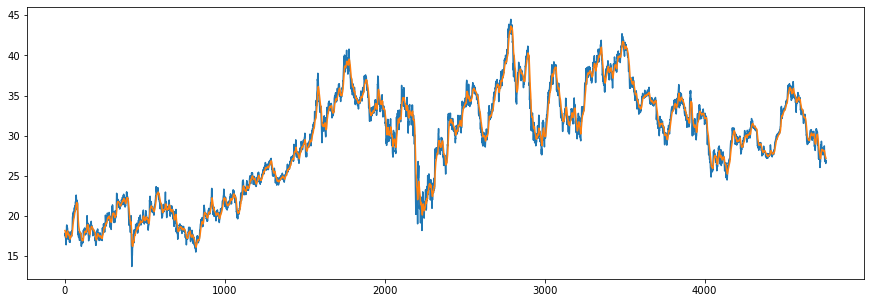

In [9]:
willr_data = []
price_data = []
ema_data = []
obv_data = []
labels = []

for filepath in glob.iglob('full cycle data/*_acc_data.csv'):
    print(filepath)
    seed = 10
    df = pd.read_csv(filepath)
    df.set_index('Date', inplace=True)
    print(df.head())
    
    plt.figure(figsize=(15,5))
    plt.plot(df['previous_1d'].values)
    plt.plot(df['EMA_12'].values)
    plt.show()

    data_15_price = []
    data_15_willr = []
    data_15_ema = []
    data_15_obv = []
    count = 0

    for i in df.values:
        if count == 14:
            data_15_price.append([i[0]])
            data_15_ema.append([i[1]])
            data_15_willr.append([i[2]])
            data_15_obv.append([i[3]])
            min_max_scaler = preprocessing.MinMaxScaler()
            data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
            data_15_ema_arr = min_max_scaler.fit_transform(data_15_ema)
            data_15_willr_arr = min_max_scaler.fit_transform(data_15_willr)
            data_15_obv_arr = min_max_scaler.fit_transform(data_15_obv)
            price_data.append(data_15_price_arr)
            willr_data.append(data_15_willr_arr)
            ema_data.append(data_15_ema_arr)
            obv_data.append(data_15_obv_arr)
            labels.append(i[-1])
            data_15_price = data_15_price[1:]
            data_15_willr = data_15_willr[1:]
            data_15_obv = data_15_obv[1:]
            data_15_ema = data_15_ema[1:]

        else:
            data_15_price.append([i[0]])
            data_15_ema.append([i[1]])
            data_15_willr.append([i[2]])
            data_15_obv.append([i[3]])
            count += 1

In [10]:
willr_data = np.array(willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
obv_data = np.array(obv_data)
obv_data.shape

(4745, 15, 1)

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [12]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
y = np.array(y)

X.shape

(4745, 64, 64, 1)

In [13]:
from collections import Counter

Counter(y)

Counter({2.0: 4314, 1.0: 216, 0.0: 215})

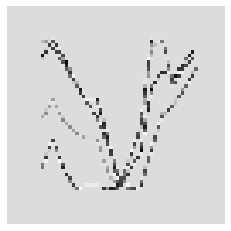

In [14]:
# plot the image array X
i = X[0].reshape(64, 64)
fig2, ax2 = plt.subplots()
plt.imshow(i, interpolation="none", cmap="gray")

ax2.axis('off')

plt.show()

In [15]:
X = X/255

In [16]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [17]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [18]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [19]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten,BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.regularizers import l2
import efficientnet.tfkeras as efn
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(Conv2D(16, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5), input_shape=X_train.shape[1:]))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Conv2D(32, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

# model.add(Dense(128, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))
# model.add(Dropout(0.25, seed=seed))

model.add(Dense(64, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(32, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(3, use_bias=True, activation=None))

In [20]:
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa

opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "DBS_CNN_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))
print(d_class_weights)

epochs = 0 
histories = {}
log_hist = {}

while epochs < 200:
    
    print('\n\n')
    print("RUNNING EPOCHS {} - {}".format(epochs,epochs+20))
    print('\n\n')
    
    column_names = ["Test_accuracy","correct_buys","correct_sells","correct_holds","correct_low_buys","correct_high_sells","correct_mid_holds","Profit gained","buy_n_hold profit"]
    log  = pd.DataFrame(columns = column_names)
    logger = []

    # Train model
    histories['epochs{}-{}'.format(epochs,epochs+20)] = model.fit(
        train_x, train_y,
        batch_size=BATCH_SIZE,
        epochs=20,
        validation_data=(validation_x, validation_y),
        shuffle=True,
        callbacks=[tensorboard],
        class_weight=d_class_weights
    )
    
    score = model.evaluate(validation_x, validation_y, verbose=0)
    print('Validation loss:', score[0])
    print('Validation accuracy:', score[1])
    
    test_sets = ['accumulation phase data','mark up phase data','distribution phase data','mark down phase data','bull phase data','bear phase data','full cycle data']
    
    for name in test_sets:
        
        print('\n')
        print(name)
        print('\n')
        
        X = test_data['{}_X'.format(name)]
        y = test_data['{}_y'.format(name)]

        score = model.evaluate(X, y)
        print('Test loss:', score[0])
        print('Test accuracy:', score[1])
        print('\n')
        logger.append(score[1]) 
        
        predictions = model.predict(X)
        predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
        actual = [np.argmax(i, axis=None, out=None) for i in y]
        
        df = pd.read_csv("{}/test_data.csv".format(name))
        df.set_index('Date', inplace=True)
        df = df.iloc[14:]
        df['predictions'] = predictions
        df['actual'] = actual
        df['previous_1d'] = df['previous_1d'].shift(-1)
        df.dropna(inplace=True)
        
        prediction = df['predictions'].values.tolist()
        price = df['previous_1d'].values.tolist()
        
        logger = pred_acc(actual, predictions, logger)
        print('\n')
        logger = correct_maxima_minima(prediction, price, logger)
        print('\n')
        logger = profit(prediction, price, logger)
        
        df_length = len(log)
        log.loc[df_length] = logger
        print(log.head(20))
        logger = []

    log.to_csv('{}_{}epochs.csv'.format(experiment,epochs))
    log_hist['{}_epochs_logs'.format(epochs)] = log
    epochs = epochs + 20

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 1 ... 1 2 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


{0: 7.3565891472868215, 1: 7.3140655105973025, 2: 0.36665700763063847}



RUNNING EPOCHS 0 - 20



Epoch 1/20
 1/30 [>.............................] - ETA: 0s - loss: 0.3586 - accuracy: 0.6953 - mse: 5.5304 - weighted_accuracy: 0.3771 - weighted_mse: 5.3024WARNING:tensorflow:From C:\Users\Shearman Chua\anaconda3\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
30/30 [==============================] - 1s 22ms/step - loss: 0.2472 - accuracy: 0.3430 - mse: 1.6856 - weighted_accuracy: 0.3387 - weighted_mse: 1.6550 - val_loss: 0.2319 - val_accuracy: 0.0464 - val_mse: 1.0292 - val_weighted_accuracy: 0.0464 - val_weighted_mse: 1.0292
Epoch 2/20
30/30 [==============================] - 0s 9ms/step - loss: 0.2073 - accuracy: 0.2474 - mse: 1.2108 - weighted_accuracy: 0.3384 - weighted_mse: 1.1918 - val_loss: 0.2177

7/7 [==============================] - 0s 5ms/step - loss: 0.2058 - accuracy: 0.0594 - mse: 0.9577 - weighted_accuracy: 0.0594 - weighted_mse: 0.9577
Test loss: 0.20580628514289856
Test accuracy: 0.05936073139309883


number of predictions: 219
actual predicted buys: 6
actual buys but predicted sell: 1
actual buys but predicted hold: 0
actual sells but predicted buy: 4
actual predicted sells: 7
actual sells but predicted hold: 0
actual holds but predicted buy: 118
actual holds but predicted sell: 83
actual predicted holds: 0
Percentage buys correct: 4.6875%
Percentage sells correct: 7.6923076923076925%
Percentage holds correct: 0%
actual buys: 7
actual sells: 11
actual holds: 201


Percentage low buys correct: 49.60629921259842%
Percentage high sells correct: 45.05494505494506%
Percentage mid holds correct: 0%


Capital: 100
Share price: $0.2096306458156978
Shares owned at the moment: 475
Cash capital at the moment: $0.15161320644678256


Price increase from previously bought: 6.070021

9/9 [==============================] - 0s 2ms/step - loss: 0.2070 - accuracy: 0.0755 - mse: 0.9698 - weighted_accuracy: 0.0755 - weighted_mse: 0.9698
Test loss: 0.20702850818634033
Test accuracy: 0.07553956657648087


number of predictions: 278
actual predicted buys: 13
actual buys but predicted sell: 3
actual buys but predicted hold: 0
actual sells but predicted buy: 5
actual predicted sells: 8
actual sells but predicted hold: 0
actual holds but predicted buy: 160
actual holds but predicted sell: 89
actual predicted holds: 0
Percentage buys correct: 7.303370786516854%
Percentage sells correct: 8.0%
Percentage holds correct: 0%
actual buys: 16
actual sells: 13
actual holds: 249


Percentage low buys correct: 40.67796610169491%
Percentage high sells correct: 43.0%
Percentage mid holds correct: 0%


Capital: 100
Share price: $0.8557023478457203
Shares owned at the moment: 116
Cash capital at the moment: $0.4655586009336474


Price increase from previously bought: 5.061539397569548%
Share

Cash capital at the moment: $0.6950708547922204


Price increase from previously bought: 4.273252504456981%
Share price: $0.7945568723180287
Shares owned at the moment: 0
Cash capital at the moment: $533.9613197933829


Share price: $0.7437350727064593
Shares owned at the moment: 715
Cash capital at the moment: $0.7283737215553856


Price increase from previously bought: 10.67625679899631%
Share price: $0.8254017688549782
Shares owned at the moment: 0
Cash capital at the moment: $589.2676922248537


Share price: $0.8327622642399453
Shares owned at the moment: 705
Cash capital at the moment: $0.5557780958970397


Price increase from previously bought: 3.526951404630463%
Share price: $0.864504251423482
Shares owned at the moment: 0
Cash capital at the moment: $608.3552177320045


Share price: $0.837281972577385
Shares owned at the moment: 724
Cash capital at the moment: $0.49604117857609253


Price increase from previously bought: -10.182090830299906%
Share price: $0.7540972418182945
Sha

5         -91.884658  


full cycle data


29/29 [==============================] - 0s 2ms/step - loss: 0.2063 - accuracy: 0.0698 - mse: 0.9606 - weighted_accuracy: 0.0698 - weighted_mse: 0.9606
Test loss: 0.20630544424057007
Test accuracy: 0.06979279965162277


number of predictions: 917
actual predicted buys: 37
actual buys but predicted sell: 9
actual buys but predicted hold: 0
actual sells but predicted buy: 13
actual predicted sells: 27
actual sells but predicted hold: 0
actual holds but predicted buy: 487
actual holds but predicted sell: 344
actual predicted holds: 0
Percentage buys correct: 6.890130353817504%
Percentage sells correct: 7.105263157894737%
Percentage holds correct: 0%
actual buys: 46
actual sells: 40
actual holds: 831


Percentage low buys correct: 46.26865671641791%
Percentage high sells correct: 44.21052631578947%
Percentage mid holds correct: 0%


Capital: 100
Share price: $0.348221810041456
Shares owned at the moment: 286
Cash capital at the moment: $0.13468587

Share price: $0.7396058042837459
Shares owned at the moment: 54
Cash capital at the moment: $0.5086565734784827


Price increase from previously bought: 1.4560141277082606%
Share price: $0.7524380993489972
Shares owned at the moment: 0
Cash capital at the moment: $41.028576880571


Share price: $0.7909348971318924
Shares owned at the moment: 51
Cash capital at the moment: $0.5799685075217411


Price increase from previously bought: -17.494042925588705%
Share price: $0.6543629698326423
Shares owned at the moment: 0
Cash capital at the moment: $33.86070556246747


Share price: $0.6396975397082745
Shares owned at the moment: 52
Cash capital at the moment: $0.5049567494589127


Price increase from previously bought: -24.994567232312303%
Share price: $0.48112737980961384
Shares owned at the moment: 0
Cash capital at the moment: $25.454779284246058


Share price: $0.46004584585904973
Shares owned at the moment: 55
Cash capital at the moment: $0.08267582781214244


Price increase from previou

Epoch 1/20
30/30 [==============================] - 1s 22ms/step - loss: 0.1979 - accuracy: 0.3164 - mse: 1.1668 - weighted_accuracy: 0.3783 - weighted_mse: 1.1771 - val_loss: 0.2074 - val_accuracy: 0.0685 - val_mse: 1.0532 - val_weighted_accuracy: 0.0685 - val_weighted_mse: 1.0532
Epoch 2/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1991 - accuracy: 0.2682 - mse: 1.1875 - weighted_accuracy: 0.3955 - weighted_mse: 1.1744 - val_loss: 0.1980 - val_accuracy: 0.0685 - val_mse: 1.0466 - val_weighted_accuracy: 0.0685 - val_weighted_mse: 1.0466
Epoch 3/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1954 - accuracy: 0.3222 - mse: 1.1992 - weighted_accuracy: 0.4227 - weighted_mse: 1.1792 - val_loss: 0.1944 - val_accuracy: 0.0674 - val_mse: 1.0975 - val_weighted_accuracy: 0.0674 - val_weighted_mse: 1.0975
Epoch 4/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1952 - accuracy: 0.3251 - mse: 1.2011 - weighted_accuracy: 0.4238 - weighted_ms

7/7 [==============================] - 0s 2ms/step - loss: 0.1886 - accuracy: 0.1872 - mse: 0.9865 - weighted_accuracy: 0.1872 - weighted_mse: 0.9865
Test loss: 0.18864327669143677
Test accuracy: 0.18721461296081543


number of predictions: 219
actual predicted buys: 6
actual buys but predicted sell: 1
actual buys but predicted hold: 0
actual sells but predicted buy: 3
actual predicted sells: 6
actual sells but predicted hold: 2
actual holds but predicted buy: 101
actual holds but predicted sell: 71
actual predicted holds: 29
Percentage buys correct: 5.454545454545454%
Percentage sells correct: 7.6923076923076925%
Percentage holds correct: 93.54838709677419%
actual buys: 7
actual sells: 11
actual holds: 201


Percentage low buys correct: 52.293577981651374%
Percentage high sells correct: 48.717948717948715%
Percentage mid holds correct: 83.87096774193549%


Capital: 100
Share price: $0.2096306458156978
Shares owned at the moment: 475
Cash capital at the moment: $0.15161320644678256


P

2         -35.065241  


mark down phase data


9/9 [==============================] - 0s 2ms/step - loss: 0.1904 - accuracy: 0.1978 - mse: 1.0041 - weighted_accuracy: 0.1978 - weighted_mse: 1.0041
Test loss: 0.190384641289711
Test accuracy: 0.19784173369407654


number of predictions: 278
actual predicted buys: 12
actual buys but predicted sell: 0
actual buys but predicted hold: 4
actual sells but predicted buy: 3
actual predicted sells: 7
actual sells but predicted hold: 3
actual holds but predicted buy: 140
actual holds but predicted sell: 73
actual predicted holds: 36
Percentage buys correct: 7.741935483870968%
Percentage sells correct: 8.75%
Percentage holds correct: 83.72093023255815%
actual buys: 16
actual sells: 13
actual holds: 249


Percentage low buys correct: 41.55844155844156%
Percentage high sells correct: 46.25%
Percentage mid holds correct: 76.74418604651163%


Capital: 100
Share price: $0.8557023478457203
Shares owned at the moment: 116
Cash capital at the moment: $0.4

Cash capital at the moment: $0.1944463797628373


Price increase from previously bought: 8.133284913801475%
Share price: $0.5194823464072713
Shares owned at the moment: 0
Cash capital at the moment: $527.0551304236433


Share price: $0.7599051667086432
Shares owned at the moment: 691
Cash capital at the moment: $0.5166504349326715


Price increase from previously bought: 4.273252504456981%
Share price: $0.7945568723180287
Shares owned at the moment: 0
Cash capital at the moment: $548.0455925100682


Share price: $0.7437350727064593
Shares owned at the moment: 734
Cash capital at the moment: $0.6428198992690568


Price increase from previously bought: 10.67625679899631%
Share price: $0.8254017688549782
Shares owned at the moment: 0
Cash capital at the moment: $604.8216447683892


Share price: $0.8466781196643112
Shares owned at the moment: 712
Cash capital at the moment: $0.3290278090968286


Price increase from previously bought: -0.05751146654311423%
Share price: $0.8485182084131098
S

29/29 [==============================] - 0s 2ms/step - loss: 0.1895 - accuracy: 0.2334 - mse: 1.0081 - weighted_accuracy: 0.2334 - weighted_mse: 1.0081
Test loss: 0.18953122198581696
Test accuracy: 0.23336967825889587


number of predictions: 917
actual predicted buys: 32
actual buys but predicted sell: 7
actual buys but predicted hold: 7
actual sells but predicted buy: 5
actual predicted sells: 26
actual sells but predicted hold: 9
actual holds but predicted buy: 411
actual holds but predicted sell: 264
actual predicted holds: 156
Percentage buys correct: 7.142857142857143%
Percentage sells correct: 8.754208754208754%
Percentage holds correct: 90.69767441860465%
actual buys: 46
actual sells: 40
actual holds: 831


Percentage low buys correct: 48.993288590604024%
Percentage high sells correct: 49.158249158249156%
Percentage mid holds correct: 84.30232558139535%


Capital: 100
Share price: $0.3088084010225731
Shares owned at the moment: 322
Cash capital at the moment: $0.290245031625957

Epoch 1/20
30/30 [==============================] - 0s 12ms/step - loss: 0.1816 - accuracy: 0.2979 - mse: 1.2277 - weighted_accuracy: 0.5349 - weighted_mse: 1.2168 - val_loss: 0.1911 - val_accuracy: 0.1412 - val_mse: 1.0862 - val_weighted_accuracy: 0.1412 - val_weighted_mse: 1.0862
Epoch 2/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1829 - accuracy: 0.2890 - mse: 1.2878 - weighted_accuracy: 0.5224 - weighted_mse: 1.2595 - val_loss: 0.1933 - val_accuracy: 0.1043 - val_mse: 1.1046 - val_weighted_accuracy: 0.1043 - val_weighted_mse: 1.1046
Epoch 3/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1814 - accuracy: 0.2547 - mse: 1.2769 - weighted_accuracy: 0.5117 - weighted_mse: 1.2332 - val_loss: 0.1893 - val_accuracy: 0.1507 - val_mse: 1.1060 - val_weighted_accuracy: 0.1507 - val_weighted_mse: 1.1060
Epoch 4/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1814 - accuracy: 0.2716 - mse: 1.2638 - weighted_accuracy: 0.5125 - weighted_ms

7/7 [==============================] - 0s 2ms/step - loss: 0.1948 - accuracy: 0.1233 - mse: 1.1015 - weighted_accuracy: 0.1233 - weighted_mse: 1.1015
Test loss: 0.19481724500656128
Test accuracy: 0.12328767031431198


number of predictions: 219
actual predicted buys: 6
actual buys but predicted sell: 1
actual buys but predicted hold: 0
actual sells but predicted buy: 3
actual predicted sells: 7
actual sells but predicted hold: 1
actual holds but predicted buy: 105
actual holds but predicted sell: 82
actual predicted holds: 14
Percentage buys correct: 5.2631578947368425%
Percentage sells correct: 7.777777777777778%
Percentage holds correct: 93.33333333333333%
actual buys: 7
actual sells: 11
actual holds: 201


Percentage low buys correct: 51.32743362831859%
Percentage high sells correct: 45.55555555555556%
Percentage mid holds correct: 86.66666666666667%


Capital: 100
Share price: $0.2096306458156978
Shares owned at the moment: 475
Cash capital at the moment: $0.15161320644678256


Pri

9/9 [==============================] - 0s 2ms/step - loss: 0.1950 - accuracy: 0.1475 - mse: 1.1232 - weighted_accuracy: 0.1475 - weighted_mse: 1.1232
Test loss: 0.19503583014011383
Test accuracy: 0.1474820077419281


number of predictions: 278
actual predicted buys: 13
actual buys but predicted sell: 0
actual buys but predicted hold: 3
actual sells but predicted buy: 2
actual predicted sells: 8
actual sells but predicted hold: 3
actual holds but predicted buy: 144
actual holds but predicted sell: 85
actual predicted holds: 20
Percentage buys correct: 8.176100628930818%
Percentage sells correct: 8.602150537634408%
Percentage holds correct: 76.92307692307692%
actual buys: 16
actual sells: 13
actual holds: 249


Percentage low buys correct: 42.40506329113924%
Percentage high sells correct: 48.38709677419355%
Percentage mid holds correct: 65.38461538461539%


Capital: 100
Share price: $0.8557023478457203
Shares owned at the moment: 116
Cash capital at the moment: $0.4655586009336474


Pric

7/7 [==============================] - 0s 2ms/step - loss: 0.1933 - accuracy: 0.1538 - mse: 1.0921 - weighted_accuracy: 0.1538 - weighted_mse: 1.0921
Test loss: 0.1932809203863144
Test accuracy: 0.1538461595773697


number of predictions: 208
actual predicted buys: 7
actual buys but predicted sell: 0
actual buys but predicted hold: 2
actual sells but predicted buy: 2
actual predicted sells: 5
actual sells but predicted hold: 3
actual holds but predicted buy: 60
actual holds but predicted sell: 109
actual predicted holds: 20
Percentage buys correct: 10.144927536231885%
Percentage sells correct: 4.385964912280702%
Percentage holds correct: 80.0%
actual buys: 9
actual sells: 10
actual holds: 189


Percentage low buys correct: 50.72463768115942%
Percentage high sells correct: 48.67256637168141%
Percentage mid holds correct: 76.0%


Capital: 100
Share price: $0.09936061724328947
Shares owned at the moment: 1003
Cash capital at the moment: $0.06723948246934697


Price increase from previousl

29/29 [==============================] - 0s 2ms/step - loss: 0.1958 - accuracy: 0.1756 - mse: 1.1242 - weighted_accuracy: 0.1756 - weighted_mse: 1.1242
Test loss: 0.19579173624515533
Test accuracy: 0.17557251453399658


number of predictions: 917
actual predicted buys: 36
actual buys but predicted sell: 7
actual buys but predicted hold: 3
actual sells but predicted buy: 5
actual predicted sells: 31
actual sells but predicted hold: 4
actual holds but predicted buy: 435
actual holds but predicted sell: 302
actual predicted holds: 94
Percentage buys correct: 7.563025210084033%
Percentage sells correct: 9.117647058823529%
Percentage holds correct: 93.06930693069307%
actual buys: 46
actual sells: 40
actual holds: 831


Percentage low buys correct: 49.26315789473684%
Percentage high sells correct: 51.76470588235294%
Percentage mid holds correct: 88.11881188118812%


Capital: 100
Share price: $0.348221810041456
Shares owned at the moment: 286
Cash capital at the moment: $0.1346858745459656




Epoch 1/20
30/30 [==============================] - 0s 12ms/step - loss: 0.1689 - accuracy: 0.2958 - mse: 1.3561 - weighted_accuracy: 0.5763 - weighted_mse: 1.3099 - val_loss: 0.1942 - val_accuracy: 0.1507 - val_mse: 1.1932 - val_weighted_accuracy: 0.1507 - val_weighted_mse: 1.1932
Epoch 2/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1664 - accuracy: 0.2779 - mse: 1.3825 - weighted_accuracy: 0.5863 - weighted_mse: 1.3485 - val_loss: 0.1909 - val_accuracy: 0.1834 - val_mse: 1.2690 - val_weighted_accuracy: 0.1834 - val_weighted_mse: 1.2690
Epoch 3/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1663 - accuracy: 0.2985 - mse: 1.4003 - weighted_accuracy: 0.5940 - weighted_mse: 1.3594 - val_loss: 0.1907 - val_accuracy: 0.1918 - val_mse: 1.2118 - val_weighted_accuracy: 0.1918 - val_weighted_mse: 1.2118
Epoch 4/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1653 - accuracy: 0.3051 - mse: 1.3895 - weighted_accuracy: 0.5871 - weighted_ms

7/7 [==============================] - 0s 4ms/step - loss: 0.1976 - accuracy: 0.1918 - mse: 1.3242 - weighted_accuracy: 0.1918 - weighted_mse: 1.3242
Test loss: 0.19762125611305237
Test accuracy: 0.19178082048892975


number of predictions: 219
actual predicted buys: 6
actual buys but predicted sell: 1
actual buys but predicted hold: 0
actual sells but predicted buy: 3
actual predicted sells: 7
actual sells but predicted hold: 1
actual holds but predicted buy: 96
actual holds but predicted sell: 76
actual predicted holds: 29
Percentage buys correct: 5.714285714285714%
Percentage sells correct: 8.333333333333334%
Percentage holds correct: 96.66666666666667%
actual buys: 7
actual sells: 11
actual holds: 201


Percentage low buys correct: 50.96153846153846%
Percentage high sells correct: 46.42857142857143%
Percentage mid holds correct: 90.0%


Capital: 100
Share price: $0.22214604861775533
Shares owned at the moment: 448
Cash capital at the moment: $0.2048862873485291


Price increase fro

9/9 [==============================] - 0s 2ms/step - loss: 0.1996 - accuracy: 0.2014 - mse: 1.3643 - weighted_accuracy: 0.2014 - weighted_mse: 1.3643
Test loss: 0.19964627921581268
Test accuracy: 0.20143884420394897


number of predictions: 278
actual predicted buys: 14
actual buys but predicted sell: 0
actual buys but predicted hold: 2
actual sells but predicted buy: 1
actual predicted sells: 8
actual sells but predicted hold: 4
actual holds but predicted buy: 135
actual holds but predicted sell: 80
actual predicted holds: 34
Percentage buys correct: 9.333333333333334%
Percentage sells correct: 9.090909090909092%
Percentage holds correct: 85.0%
actual buys: 16
actual sells: 13
actual holds: 249


Percentage low buys correct: 43.624161073825505%
Percentage high sells correct: 46.59090909090909%
Percentage mid holds correct: 77.5%


Capital: 100
Share price: $0.8557023478457203
Shares owned at the moment: 116
Cash capital at the moment: $0.4655586009336474


Price increase from previous

7/7 [==============================] - 0s 4ms/step - loss: 0.1954 - accuracy: 0.1875 - mse: 1.3116 - weighted_accuracy: 0.1875 - weighted_mse: 1.3116
Test loss: 0.1953527331352234
Test accuracy: 0.1875


number of predictions: 208
actual predicted buys: 5
actual buys but predicted sell: 1
actual buys but predicted hold: 3
actual sells but predicted buy: 1
actual predicted sells: 6
actual sells but predicted hold: 3
actual holds but predicted buy: 57
actual holds but predicted sell: 104
actual predicted holds: 28
Percentage buys correct: 7.936507936507937%
Percentage sells correct: 5.405405405405405%
Percentage holds correct: 82.3529411764706%
actual buys: 9
actual sells: 10
actual holds: 189


Percentage low buys correct: 53.96825396825397%
Percentage high sells correct: 50.450450450450454%
Percentage mid holds correct: 78.78787878787878%


Capital: 100
Share price: $0.09936061724328947
Shares owned at the moment: 1003
Cash capital at the moment: $0.06723948246934697


Price increase f

Shares owned at the moment: 0
Cash capital at the moment: $38.838266577784246


Share price: $0.06853421242122103
Shares owned at the moment: 565
Cash capital at the moment: $0.00995152724489401


Price increase from previously bought: -85.44876337629923%
Share price: $0.01
Shares owned at the moment: 0
Cash capital at the moment: $5.644414027244895


Share price: $0.022788993106618742
Shares owned at the moment: 247
Cash capital at the moment: $5.3306342394421335e-05


Price increase from previously bought: 540.005362549048%
Share price: $0.1462518675926644
Shares owned at the moment: 0
Cash capital at the moment: $36.02492302066818


Share price: $0.11280374620910914
Shares owned at the moment: 318
Cash capital at the moment: $0.054684850111605954




Capital at the end of test period: $19.136818176842382
profit gained: -80.86318182315762%


Capital at the end of test period if Buy and Hold: $8.115342010843221
profit gained: -91.88465798915678%
   Test_accuracy  correct_buys  correct

Epoch 1/20
30/30 [==============================] - 1s 19ms/step - loss: 0.1502 - accuracy: 0.3346 - mse: 1.4888 - weighted_accuracy: 0.6567 - weighted_mse: 1.4918 - val_loss: 0.1916 - val_accuracy: 0.2645 - val_mse: 1.3444 - val_weighted_accuracy: 0.2645 - val_weighted_mse: 1.3444
Epoch 2/20
30/30 [==============================] - 0s 15ms/step - loss: 0.1528 - accuracy: 0.3451 - mse: 1.4918 - weighted_accuracy: 0.6404 - weighted_mse: 1.4526 - val_loss: 0.1888 - val_accuracy: 0.2982 - val_mse: 1.3186 - val_weighted_accuracy: 0.2982 - val_weighted_mse: 1.3186
Epoch 3/20
30/30 [==============================] - 0s 15ms/step - loss: 0.1479 - accuracy: 0.3659 - mse: 1.5331 - weighted_accuracy: 0.6535 - weighted_mse: 1.5266 - val_loss: 0.1887 - val_accuracy: 0.2950 - val_mse: 1.3475 - val_weighted_accuracy: 0.2950 - val_weighted_mse: 1.3475
Epoch 4/20
30/30 [==============================] - 0s 15ms/step - loss: 0.1494 - accuracy: 0.3699 - mse: 1.4745 - weighted_accuracy: 0.6458 - weighted

7/7 [==============================] - 0s 5ms/step - loss: 0.1755 - accuracy: 0.4384 - mse: 1.3934 - weighted_accuracy: 0.4384 - weighted_mse: 1.3934
Test loss: 0.17552722990512848
Test accuracy: 0.4383561611175537


number of predictions: 219
actual predicted buys: 6
actual buys but predicted sell: 1
actual buys but predicted hold: 0
actual sells but predicted buy: 3
actual predicted sells: 6
actual sells but predicted hold: 2
actual holds but predicted buy: 67
actual holds but predicted sell: 50
actual predicted holds: 84
Percentage buys correct: 7.894736842105263%
Percentage sells correct: 10.526315789473685%
Percentage holds correct: 97.67441860465117%
actual buys: 7
actual sells: 11
actual holds: 201


Percentage low buys correct: 48.0%
Percentage high sells correct: 45.6140350877193%
Percentage mid holds correct: 89.53488372093024%


Capital: 100
Share price: $0.14028312979928814
Shares owned at the moment: 710
Cash capital at the moment: $0.12507503157230815


Price increase fro

9/9 [==============================] - 0s 4ms/step - loss: 0.1835 - accuracy: 0.3885 - mse: 1.4384 - weighted_accuracy: 0.3885 - weighted_mse: 1.4384
Test loss: 0.18353453278541565
Test accuracy: 0.3884892165660858


number of predictions: 278
actual predicted buys: 8
actual buys but predicted sell: 0
actual buys but predicted hold: 8
actual sells but predicted buy: 1
actual predicted sells: 4
actual sells but predicted hold: 8
actual holds but predicted buy: 97
actual holds but predicted sell: 56
actual predicted holds: 96
Percentage buys correct: 7.547169811320755%
Percentage sells correct: 6.666666666666667%
Percentage holds correct: 85.71428571428571%
actual buys: 16
actual sells: 13
actual holds: 249


Percentage low buys correct: 48.113207547169814%
Percentage high sells correct: 50.0%
Percentage mid holds correct: 78.37837837837837%


Capital: 100
Share price: $0.8557023478457203
Shares owned at the moment: 116
Cash capital at the moment: $0.4655586009336474


Price increase fro

19/19 [==============================] - 0s 5ms/step - loss: 0.1797 - accuracy: 0.4269 - mse: 1.3846 - weighted_accuracy: 0.4269 - weighted_mse: 1.3846
Test loss: 0.17973852157592773
Test accuracy: 0.4268907606601715


number of predictions: 595
actual predicted buys: 16
actual buys but predicted sell: 2
actual buys but predicted hold: 14
actual sells but predicted buy: 3
actual predicted sells: 8
actual sells but predicted hold: 16
actual holds but predicted buy: 180
actual holds but predicted sell: 126
actual predicted holds: 230
Percentage buys correct: 8.040201005025125%
Percentage sells correct: 5.882352941176471%
Percentage holds correct: 88.46153846153847%
actual buys: 32
actual sells: 27
actual holds: 536


Percentage low buys correct: 50.753768844221106%
Percentage high sells correct: 51.470588235294116%
Percentage mid holds correct: 80.6949806949807%


Capital: 100
Share price: $0.8476783448379387
Shares owned at the moment: 117
Cash capital at the moment: $0.5488931465095561

29/29 [==============================] - 0s 6ms/step - loss: 0.1822 - accuracy: 0.4395 - mse: 1.4138 - weighted_accuracy: 0.4395 - weighted_mse: 1.4138
Test loss: 0.1821591854095459
Test accuracy: 0.43947654962539673


number of predictions: 917
actual predicted buys: 25
actual buys but predicted sell: 6
actual buys but predicted hold: 15
actual sells but predicted buy: 3
actual predicted sells: 19
actual sells but predicted hold: 18
actual holds but predicted buy: 289
actual holds but predicted sell: 183
actual predicted holds: 359
Percentage buys correct: 7.886435331230284%
Percentage sells correct: 9.134615384615385%
Percentage holds correct: 91.58163265306122%
actual buys: 46
actual sells: 40
actual holds: 831


Percentage low buys correct: 50.0%
Percentage high sells correct: 52.88461538461539%
Percentage mid holds correct: 84.94897959183673%


Capital: 100
Share price: $0.3088084010225731
Shares owned at the moment: 322
Cash capital at the moment: $0.2902450316259575


Price incr

Epoch 1/20
30/30 [==============================] - 1s 18ms/step - loss: 0.1356 - accuracy: 0.4589 - mse: 1.6494 - weighted_accuracy: 0.6986 - weighted_mse: 1.6939 - val_loss: 0.1801 - val_accuracy: 0.4310 - val_mse: 1.5198 - val_weighted_accuracy: 0.4310 - val_weighted_mse: 1.5198
Epoch 2/20
30/30 [==============================] - 0s 15ms/step - loss: 0.1369 - accuracy: 0.4586 - mse: 1.6483 - weighted_accuracy: 0.6875 - weighted_mse: 1.6952 - val_loss: 0.1784 - val_accuracy: 0.4384 - val_mse: 1.5095 - val_weighted_accuracy: 0.4384 - val_weighted_mse: 1.5095
Epoch 3/20
30/30 [==============================] - 0s 14ms/step - loss: 0.1341 - accuracy: 0.4523 - mse: 1.6946 - weighted_accuracy: 0.7035 - weighted_mse: 1.7610 - val_loss: 0.1770 - val_accuracy: 0.4552 - val_mse: 1.4741 - val_weighted_accuracy: 0.4552 - val_weighted_mse: 1.4741
Epoch 4/20
30/30 [==============================] - 0s 15ms/step - loss: 0.1310 - accuracy: 0.4642 - mse: 1.6614 - weighted_accuracy: 0.7115 - weighted

7/7 [==============================] - 0s 4ms/step - loss: 0.1612 - accuracy: 0.6027 - mse: 1.5433 - weighted_accuracy: 0.6027 - weighted_mse: 1.5433
Test loss: 0.1612144410610199
Test accuracy: 0.6027397513389587


number of predictions: 219
actual predicted buys: 6
actual buys but predicted sell: 0
actual buys but predicted hold: 1
actual sells but predicted buy: 3
actual predicted sells: 4
actual sells but predicted hold: 4
actual holds but predicted buy: 59
actual holds but predicted sell: 20
actual predicted holds: 122
Percentage buys correct: 8.823529411764707%
Percentage sells correct: 16.666666666666668%
Percentage holds correct: 96.06299212598425%
actual buys: 7
actual sells: 11
actual holds: 201


Percentage low buys correct: 47.76119402985075%
Percentage high sells correct: 50.0%
Percentage mid holds correct: 86.61417322834646%


Capital: 100
Share price: $0.14028312979928814
Shares owned at the moment: 710
Cash capital at the moment: $0.12507503157230815


Price increase fr

9/9 [==============================] - 0s 5ms/step - loss: 0.1758 - accuracy: 0.4784 - mse: 1.6330 - weighted_accuracy: 0.4784 - weighted_mse: 1.6330
Test loss: 0.17583955824375153
Test accuracy: 0.4784172773361206


number of predictions: 278
actual predicted buys: 6
actual buys but predicted sell: 0
actual buys but predicted hold: 10
actual sells but predicted buy: 1
actual predicted sells: 4
actual sells but predicted hold: 8
actual holds but predicted buy: 92
actual holds but predicted sell: 34
actual predicted holds: 123
Percentage buys correct: 6.0606060606060606%
Percentage sells correct: 10.526315789473685%
Percentage holds correct: 87.23404255319149%
actual buys: 16
actual sells: 13
actual holds: 249


Percentage low buys correct: 48.484848484848484%
Percentage high sells correct: 47.36842105263158%
Percentage mid holds correct: 80.71428571428571%


Capital: 100
Share price: $0.8866843411192987
Shares owned at the moment: 112
Cash capital at the moment: $0.4182550175737987


P

19/19 [==============================] - 0s 4ms/step - loss: 0.1677 - accuracy: 0.5412 - mse: 1.5400 - weighted_accuracy: 0.5412 - weighted_mse: 1.5400
Test loss: 0.1676935851573944
Test accuracy: 0.5411764979362488


number of predictions: 595
actual predicted buys: 19
actual buys but predicted sell: 0
actual buys but predicted hold: 13
actual sells but predicted buy: 4
actual predicted sells: 3
actual sells but predicted hold: 20
actual holds but predicted buy: 167
actual holds but predicted sell: 69
actual predicted holds: 300
Percentage buys correct: 10.0%
Percentage sells correct: 4.166666666666667%
Percentage holds correct: 90.09009009009009%
actual buys: 32
actual sells: 27
actual holds: 536


Percentage low buys correct: 51.05263157894737%
Percentage high sells correct: 56.94444444444444%
Percentage mid holds correct: 82.83132530120481%


Capital: 100
Share price: $0.8476783448379387
Shares owned at the moment: 117
Cash capital at the moment: $0.5488931465095561


Price increas

29/29 [==============================] - 0s 5ms/step - loss: 0.1718 - accuracy: 0.5311 - mse: 1.5761 - weighted_accuracy: 0.5311 - weighted_mse: 1.5761
Test loss: 0.1717986911535263
Test accuracy: 0.5310795903205872


number of predictions: 917
actual predicted buys: 24
actual buys but predicted sell: 1
actual buys but predicted hold: 21
actual sells but predicted buy: 3
actual predicted sells: 9
actual sells but predicted hold: 28
actual holds but predicted buy: 269
actual holds but predicted sell: 108
actual predicted holds: 454
Percentage buys correct: 8.108108108108109%
Percentage sells correct: 7.627118644067797%
Percentage holds correct: 90.25844930417495%
actual buys: 46
actual sells: 40
actual holds: 831


Percentage low buys correct: 49.83050847457627%
Percentage high sells correct: 50.0%
Percentage mid holds correct: 84.49304174950298%


Capital: 100
Share price: $0.3088084010225731
Shares owned at the moment: 322
Cash capital at the moment: $0.2902450316259575


Price increa

Epoch 1/20
30/30 [==============================] - 1s 18ms/step - loss: 0.1213 - accuracy: 0.5327 - mse: 1.8339 - weighted_accuracy: 0.7274 - weighted_mse: 2.0357 - val_loss: 0.1661 - val_accuracy: 0.5427 - val_mse: 1.6342 - val_weighted_accuracy: 0.5427 - val_weighted_mse: 1.6342
Epoch 2/20
30/30 [==============================] - 0s 15ms/step - loss: 0.1200 - accuracy: 0.5387 - mse: 1.8517 - weighted_accuracy: 0.7389 - weighted_mse: 2.0680 - val_loss: 0.1708 - val_accuracy: 0.5090 - val_mse: 1.6345 - val_weighted_accuracy: 0.5090 - val_weighted_mse: 1.6345
Epoch 3/20
30/30 [==============================] - 0s 14ms/step - loss: 0.1177 - accuracy: 0.5287 - mse: 1.8925 - weighted_accuracy: 0.7462 - weighted_mse: 2.1873 - val_loss: 0.1677 - val_accuracy: 0.5227 - val_mse: 1.5347 - val_weighted_accuracy: 0.5227 - val_weighted_mse: 1.5347
Epoch 4/20
30/30 [==============================] - 0s 14ms/step - loss: 0.1170 - accuracy: 0.5606 - mse: 1.8419 - weighted_accuracy: 0.7561 - weighted

7/7 [==============================] - 0s 5ms/step - loss: 0.1326 - accuracy: 0.7260 - mse: 1.5960 - weighted_accuracy: 0.7260 - weighted_mse: 1.5960
Test loss: 0.13256044685840607
Test accuracy: 0.7260273694992065


number of predictions: 219
actual predicted buys: 4
actual buys but predicted sell: 0
actual buys but predicted hold: 3
actual sells but predicted buy: 0
actual predicted sells: 3
actual sells but predicted hold: 8
actual holds but predicted buy: 34
actual holds but predicted sell: 15
actual predicted holds: 152
Percentage buys correct: 10.526315789473685%
Percentage sells correct: 16.666666666666668%
Percentage holds correct: 93.25153374233129%
actual buys: 7
actual sells: 11
actual holds: 201


Percentage low buys correct: 48.648648648648646%
Percentage high sells correct: 44.44444444444444%
Percentage mid holds correct: 85.2760736196319%


Capital: 100
Share price: $0.14028312979928814
Shares owned at the moment: 710
Cash capital at the moment: $0.12507503157230815


Pr

9/9 [==============================] - 0s 4ms/step - loss: 0.1542 - accuracy: 0.6187 - mse: 1.7012 - weighted_accuracy: 0.6187 - weighted_mse: 1.7012
Test loss: 0.15418905019760132
Test accuracy: 0.6187050342559814


number of predictions: 278
actual predicted buys: 5
actual buys but predicted sell: 0
actual buys but predicted hold: 11
actual sells but predicted buy: 1
actual predicted sells: 3
actual sells but predicted hold: 9
actual holds but predicted buy: 59
actual holds but predicted sell: 26
actual predicted holds: 164
Percentage buys correct: 7.6923076923076925%
Percentage sells correct: 10.344827586206897%
Percentage holds correct: 89.1304347826087%
actual buys: 16
actual sells: 13
actual holds: 249


Percentage low buys correct: 46.15384615384615%
Percentage high sells correct: 41.37931034482759%
Percentage mid holds correct: 81.9672131147541%


Capital: 100
Share price: $0.8836219133409499
Shares owned at the moment: 112
Cash capital at the moment: $0.7621901565046016


Pric

19/19 [==============================] - 0s 5ms/step - loss: 0.1431 - accuracy: 0.6672 - mse: 1.6013 - weighted_accuracy: 0.6672 - weighted_mse: 1.6013
Test loss: 0.1431056559085846
Test accuracy: 0.6672269105911255


number of predictions: 595
actual predicted buys: 9
actual buys but predicted sell: 1
actual buys but predicted hold: 22
actual sells but predicted buy: 0
actual predicted sells: 1
actual sells but predicted hold: 26
actual holds but predicted buy: 106
actual holds but predicted sell: 43
actual predicted holds: 387
Percentage buys correct: 7.826086956521739%
Percentage sells correct: 2.2222222222222223%
Percentage holds correct: 88.96551724137932%
actual buys: 32
actual sells: 27
actual holds: 536


Percentage low buys correct: 51.30434782608695%
Percentage high sells correct: 53.333333333333336%
Percentage mid holds correct: 81.33640552995392%


Capital: 100
Share price: $0.8476783448379387
Shares owned at the moment: 117
Cash capital at the moment: $0.5488931465095561



29/29 [==============================] - 0s 5ms/step - loss: 0.1481 - accuracy: 0.6499 - mse: 1.6413 - weighted_accuracy: 0.6499 - weighted_mse: 1.6413
Test loss: 0.1480972170829773
Test accuracy: 0.6499454975128174


number of predictions: 917
actual predicted buys: 16
actual buys but predicted sell: 2
actual buys but predicted hold: 28
actual sells but predicted buy: 3
actual predicted sells: 4
actual sells but predicted hold: 33
actual holds but predicted buy: 173
actual holds but predicted sell: 82
actual predicted holds: 576
Percentage buys correct: 8.333333333333334%
Percentage sells correct: 4.545454545454546%
Percentage holds correct: 90.42386185243328%
actual buys: 46
actual sells: 40
actual holds: 831


Percentage low buys correct: 52.87958115183246%
Percentage high sells correct: 47.72727272727273%
Percentage mid holds correct: 83.83045525902669%


Capital: 100
Share price: $0.32989002238599585
Shares owned at the moment: 302
Cash capital at the moment: $0.09923957583767162


Epoch 1/20
30/30 [==============================] - 1s 18ms/step - loss: 0.1064 - accuracy: 0.5996 - mse: 2.0502 - weighted_accuracy: 0.7685 - weighted_mse: 2.3628 - val_loss: 0.1538 - val_accuracy: 0.5975 - val_mse: 1.6431 - val_weighted_accuracy: 0.5975 - val_weighted_mse: 1.6431
Epoch 2/20
30/30 [==============================] - 0s 14ms/step - loss: 0.1112 - accuracy: 0.6067 - mse: 1.9979 - weighted_accuracy: 0.7564 - weighted_mse: 2.1916 - val_loss: 0.1502 - val_accuracy: 0.6027 - val_mse: 1.7725 - val_weighted_accuracy: 0.6027 - val_weighted_mse: 1.7725
Epoch 3/20
30/30 [==============================] - 0s 14ms/step - loss: 0.1052 - accuracy: 0.6001 - mse: 2.0920 - weighted_accuracy: 0.7724 - weighted_mse: 2.4196 - val_loss: 0.1517 - val_accuracy: 0.6059 - val_mse: 1.6615 - val_weighted_accuracy: 0.6059 - val_weighted_mse: 1.6615
Epoch 4/20
30/30 [==============================] - 0s 15ms/step - loss: 0.1057 - accuracy: 0.6022 - mse: 2.0822 - weighted_accuracy: 0.7713 - weighted

7/7 [==============================] - 0s 5ms/step - loss: 0.1147 - accuracy: 0.7717 - mse: 1.7315 - weighted_accuracy: 0.7717 - weighted_mse: 1.7315
Test loss: 0.11468115448951721
Test accuracy: 0.7716894745826721


number of predictions: 219
actual predicted buys: 3
actual buys but predicted sell: 0
actual buys but predicted hold: 4
actual sells but predicted buy: 0
actual predicted sells: 3
actual sells but predicted hold: 8
actual holds but predicted buy: 29
actual holds but predicted sell: 9
actual predicted holds: 163
Percentage buys correct: 9.375%
Percentage sells correct: 25.0%
Percentage holds correct: 93.14285714285714%
actual buys: 7
actual sells: 11
actual holds: 201


Percentage low buys correct: 35.483870967741936%
Percentage high sells correct: 58.333333333333336%
Percentage mid holds correct: 85.71428571428571%


Capital: 100
Share price: $0.14028312979928814
Shares owned at the moment: 710
Cash capital at the moment: $0.12507503157230815


Price increase from previous

9/9 [==============================] - 0s 4ms/step - loss: 0.1419 - accuracy: 0.6763 - mse: 1.8646 - weighted_accuracy: 0.6763 - weighted_mse: 1.8646
Test loss: 0.14186130464076996
Test accuracy: 0.6762589812278748


number of predictions: 278
actual predicted buys: 4
actual buys but predicted sell: 0
actual buys but predicted hold: 12
actual sells but predicted buy: 1
actual predicted sells: 1
actual sells but predicted hold: 11
actual holds but predicted buy: 51
actual holds but predicted sell: 15
actual predicted holds: 183
Percentage buys correct: 7.142857142857143%
Percentage sells correct: 6.25%
Percentage holds correct: 88.83495145631068%
actual buys: 16
actual sells: 13
actual holds: 249


Percentage low buys correct: 44.642857142857146%
Percentage high sells correct: 43.75%
Percentage mid holds correct: 82.4390243902439%


Capital: 100
Share price: $0.8836219133409499
Shares owned at the moment: 112
Cash capital at the moment: $0.7621901565046016


Price increase from previous

19/19 [==============================] - 0s 4ms/step - loss: 0.1294 - accuracy: 0.7328 - mse: 1.7509 - weighted_accuracy: 0.7328 - weighted_mse: 1.7509
Test loss: 0.12941338121891022
Test accuracy: 0.7327731251716614


number of predictions: 595
actual predicted buys: 6
actual buys but predicted sell: 1
actual buys but predicted hold: 25
actual sells but predicted buy: 1
actual predicted sells: 1
actual sells but predicted hold: 25
actual holds but predicted buy: 83
actual holds but predicted sell: 24
actual predicted holds: 429
Percentage buys correct: 6.666666666666667%
Percentage sells correct: 3.8461538461538463%
Percentage holds correct: 89.5615866388309%
actual buys: 32
actual sells: 27
actual holds: 536


Percentage low buys correct: 51.111111111111114%
Percentage high sells correct: 50.0%
Percentage mid holds correct: 82.63598326359832%


Capital: 100
Share price: $0.7999655448210515
Shares owned at the moment: 124
Cash capital at the moment: $0.5314841914056387


Price increas

Epoch 1/20
30/30 [==============================] - 1s 19ms/step - loss: 0.0920 - accuracy: 0.6552 - mse: 2.3576 - weighted_accuracy: 0.8073 - weighted_mse: 2.8904 - val_loss: 0.1272 - val_accuracy: 0.7165 - val_mse: 1.8511 - val_weighted_accuracy: 0.7165 - val_weighted_mse: 1.8511
Epoch 2/20
30/30 [==============================] - 0s 15ms/step - loss: 0.0909 - accuracy: 0.6560 - mse: 2.4035 - weighted_accuracy: 0.8021 - weighted_mse: 2.9844 - val_loss: 0.1410 - val_accuracy: 0.6617 - val_mse: 1.9571 - val_weighted_accuracy: 0.6617 - val_weighted_mse: 1.9571
Epoch 3/20
30/30 [==============================] - 0s 14ms/step - loss: 0.0912 - accuracy: 0.6565 - mse: 2.4284 - weighted_accuracy: 0.7986 - weighted_mse: 3.0536 - val_loss: 0.1371 - val_accuracy: 0.6797 - val_mse: 1.9436 - val_weighted_accuracy: 0.6797 - val_weighted_mse: 1.9436
Epoch 4/20
30/30 [==============================] - 0s 15ms/step - loss: 0.0902 - accuracy: 0.6646 - mse: 2.4110 - weighted_accuracy: 0.7924 - weighted

7/7 [==============================] - 0s 4ms/step - loss: 0.0965 - accuracy: 0.8265 - mse: 2.1208 - weighted_accuracy: 0.8265 - weighted_mse: 2.1208
Test loss: 0.0964617133140564
Test accuracy: 0.8264840245246887


number of predictions: 219
actual predicted buys: 3
actual buys but predicted sell: 0
actual buys but predicted hold: 4
actual sells but predicted buy: 0
actual predicted sells: 2
actual sells but predicted hold: 9
actual holds but predicted buy: 20
actual holds but predicted sell: 5
actual predicted holds: 176
Percentage buys correct: 13.043478260869565%
Percentage sells correct: 28.571428571428573%
Percentage holds correct: 93.12169312169313%
actual buys: 7
actual sells: 11
actual holds: 201


Percentage low buys correct: 45.45454545454545%
Percentage high sells correct: 57.142857142857146%
Percentage mid holds correct: 86.24338624338624%


Capital: 100
Share price: $0.14028312979928814
Shares owned at the moment: 710
Cash capital at the moment: $0.12507503157230815


Pri

9/9 [==============================] - 0s 4ms/step - loss: 0.1309 - accuracy: 0.7302 - mse: 2.3044 - weighted_accuracy: 0.7302 - weighted_mse: 2.3044
Test loss: 0.13088667392730713
Test accuracy: 0.730215847492218


number of predictions: 278
actual predicted buys: 2
actual buys but predicted sell: 0
actual buys but predicted hold: 14
actual sells but predicted buy: 1
actual predicted sells: 1
actual sells but predicted hold: 11
actual holds but predicted buy: 36
actual holds but predicted sell: 13
actual predicted holds: 200
Percentage buys correct: 5.128205128205129%
Percentage sells correct: 7.142857142857143%
Percentage holds correct: 88.88888888888889%
actual buys: 16
actual sells: 13
actual holds: 249


Percentage low buys correct: 48.717948717948715%
Percentage high sells correct: 50.0%
Percentage mid holds correct: 83.03571428571429%


Capital: 100
Share price: $0.8836219133409499
Shares owned at the moment: 112
Cash capital at the moment: $0.7621901565046016


Price increase f

19/19 [==============================] - 0s 4ms/step - loss: 0.1177 - accuracy: 0.7613 - mse: 2.1679 - weighted_accuracy: 0.7613 - weighted_mse: 2.1679
Test loss: 0.11769343912601471
Test accuracy: 0.7613445520401001


number of predictions: 595
actual predicted buys: 4
actual buys but predicted sell: 1
actual buys but predicted hold: 27
actual sells but predicted buy: 0
actual predicted sells: 0
actual sells but predicted hold: 27
actual holds but predicted buy: 67
actual holds but predicted sell: 20
actual predicted holds: 449
Percentage buys correct: 5.633802816901408%
Percentage sells correct: 0.0%
Percentage holds correct: 89.26441351888668%
actual buys: 32
actual sells: 27
actual holds: 536


Percentage low buys correct: 52.11267605633803%
Percentage high sells correct: 38.095238095238095%
Percentage mid holds correct: 82.47011952191235%


Capital: 100
Share price: $0.7955385820603212
Shares owned at the moment: 125
Cash capital at the moment: $0.2842108548766049


Price increase

Shares owned at the moment: 248
Cash capital at the moment: $0.022836683375260236


Price increase from previously bought: -30.446578965342784%
Share price: $0.20706691397512622
Shares owned at the moment: 0
Cash capital at the moment: $51.234211713875524


Share price: $0.16948668372178943
Shares owned at the moment: 301
Cash capital at the moment: $0.07842731116619461


Price increase from previously bought: 20.759249151845083%
Share price: $0.20523369150315107
Shares owned at the moment: 0
Cash capital at the moment: $61.683886265472935


Share price: $0.16123740113004736
Shares owned at the moment: 381
Cash capital at the moment: $0.08349994789087845


Price increase from previously bought: 52.44872422807192%
Share price: $0.24648032299400946
Shares owned at the moment: 0
Cash capital at the moment: $93.7342532501915


Share price: $0.20340055644403432
Shares owned at the moment: 459
Cash capital at the moment: $0.11665549000825592


Price increase from previously bought: -22.29472

Epoch 18/20
30/30 [==============================] - 0s 15ms/step - loss: 0.0718 - accuracy: 0.7392 - mse: 3.2247 - weighted_accuracy: 0.8603 - weighted_mse: 4.0358 - val_loss: 0.1151 - val_accuracy: 0.7682 - val_mse: 2.3527 - val_weighted_accuracy: 0.7682 - val_weighted_mse: 2.3527
Epoch 19/20
30/30 [==============================] - 0s 16ms/step - loss: 0.0697 - accuracy: 0.7445 - mse: 3.2169 - weighted_accuracy: 0.8604 - weighted_mse: 3.9467 - val_loss: 0.1243 - val_accuracy: 0.7460 - val_mse: 2.5854 - val_weighted_accuracy: 0.7460 - val_weighted_mse: 2.5854
Epoch 20/20
30/30 [==============================] - 0s 14ms/step - loss: 0.0716 - accuracy: 0.7447 - mse: 3.3928 - weighted_accuracy: 0.8568 - weighted_mse: 4.3012 - val_loss: 0.1030 - val_accuracy: 0.8156 - val_mse: 2.5135 - val_weighted_accuracy: 0.8156 - val_weighted_mse: 2.5135
Validation loss: 0.10300915688276291
Validation accuracy: 0.8155953884124756


accumulation phase data


8/8 [==============================] - 0s 4

9/9 [==============================] - 0s 5ms/step - loss: 0.1268 - accuracy: 0.7986 - mse: 2.5927 - weighted_accuracy: 0.7986 - weighted_mse: 2.5927
Test loss: 0.12684136629104614
Test accuracy: 0.798561155796051


number of predictions: 278
actual predicted buys: 0
actual buys but predicted sell: 0
actual buys but predicted hold: 16
actual sells but predicted buy: 1
actual predicted sells: 0
actual sells but predicted hold: 12
actual holds but predicted buy: 25
actual holds but predicted sell: 2
actual predicted holds: 222
Percentage buys correct: 0.0%
Percentage sells correct: 0.0%
Percentage holds correct: 88.8%
actual buys: 16
actual sells: 13
actual holds: 249


Percentage low buys correct: 38.46153846153846%
Percentage high sells correct: 50.0%
Percentage mid holds correct: 83.53413654618474%


Capital: 100
Share price: $0.8232401149455993
Shares owned at the moment: 121
Cash capital at the moment: $0.11401294333433043


Price increase from previously bought: -20.33820783943231%

29/29 [==============================] - 0s 4ms/step - loss: 0.1114 - accuracy: 0.8059 - mse: 2.4838 - weighted_accuracy: 0.8059 - weighted_mse: 2.4838
Test loss: 0.11140340566635132
Test accuracy: 0.8058887720108032


number of predictions: 917
actual predicted buys: 5
actual buys but predicted sell: 0
actual buys but predicted hold: 41
actual sells but predicted buy: 0
actual predicted sells: 1
actual sells but predicted hold: 39
actual holds but predicted buy: 74
actual holds but predicted sell: 24
actual predicted holds: 733
Percentage buys correct: 6.329113924050633%
Percentage sells correct: 4.0%
Percentage holds correct: 90.159901599016%
actual buys: 46
actual sells: 40
actual holds: 831


Percentage low buys correct: 54.43037974683544%
Percentage high sells correct: 40.0%
Percentage mid holds correct: 83.49753694581281%


Capital: 100
Share price: $0.32989002238599585
Shares owned at the moment: 302
Cash capital at the moment: $0.09923957583767162


Price increase from previous

In [21]:
df = log_hist['0_epochs_logs']
df['Profit gained']

0     -28.132020
1      40.263682
2    2106.118725
3     -95.978770
4     491.875170
5       0.378431
6     -79.356810
Name: Profit gained, dtype: float64

In [22]:
accumulation_phase_data_acc = []
mark_up_phase_data_acc = []
distribution_phase_data_acc = []
mark_down_phase_data_acc = []
bull_phase_data_acc = []
bear_phase_data_acc = []
full_cycle_data_acc = []

accumulation_phase_data_correct_buys = []
mark_up_phase_data_correct_buys = []
distribution_phase_data_correct_buys = []
mark_down_phase_data_correct_buys = []
bull_phase_data_correct_buys = []
bear_phase_data_correct_buys = []
full_cycle_data_correct_buys = []

accumulation_phase_data_correct_sells = []
mark_up_phase_data_correct_sells = []
distribution_phase_data_correct_sells = []
mark_down_phase_data_correct_sells = []
bull_phase_data_correct_sells = []
bear_phase_data_correct_sells = []
full_cycle_data_correct_sells = []

accumulation_phase_data_correct_holds = []
mark_up_phase_data_correct_holds = []
distribution_phase_data_correct_holds = []
mark_down_phase_data_correct_holds = []
bull_phase_data_correct_holds = []
bear_phase_data_correct_holds = []
full_cycle_data_correct_holds = []

accumulation_phase_data_correct_low_buys = []
mark_up_phase_data_correct_low_buys = []
distribution_phase_data_correct_low_buys = []
mark_down_phase_data_correct_low_buys = []
bull_phase_data_correct_low_buys = []
bear_phase_data_correct_low_buys = []
full_cycle_data_correct_low_buys = []

accumulation_phase_data_correct_high_sells = []
mark_up_phase_data_correct_high_sells = []
distribution_phase_data_correct_high_sells = []
mark_down_phase_data_correct_high_sells = []
bull_phase_data_correct_high_sells = []
bear_phase_data_correct_high_sells = []
full_cycle_data_correct_high_sells = []

accumulation_phase_data_correct_mid_holds = []
mark_up_phase_data_correct_mid_holds = []
distribution_phase_data_correct_mid_holds = []
mark_down_phase_data_correct_mid_holds = []
bull_phase_data_correct_mid_holds = []
bear_phase_data_correct_mid_holds = []
full_cycle_data_correct_mid_holds = []

accumulation_phase_data_profit = []
mark_up_phase_data_profit = []
distribution_phase_data_profit = []
mark_down_phase_data_profit = []
bull_phase_data_profit = []
bear_phase_data_profit = []
full_cycle_data_profit = []

for key,value in log_hist.items():
    print(key)
    df = value
    acc = df['Test_accuracy'].values.tolist()
    correct_buys = df['correct_buys'].values.tolist()
    correct_sells = df['correct_sells'].values.tolist()
    correct_holds = df['correct_holds'].values.tolist()
    correct_low_buys = df['correct_low_buys'].values.tolist()
    correct_high_sells = df['correct_high_sells'].values.tolist()
    correct_mid_holds = df['correct_mid_holds'].values.tolist()
    profit = df['Profit gained'].values.tolist()
    
    accumulation_phase_data_acc.append(acc[0])
    mark_up_phase_data_acc.append(acc[1])
    distribution_phase_data_acc.append(acc[2])
    mark_down_phase_data_acc.append(acc[3]) 
    bull_phase_data_acc.append(acc[4]) 
    bear_phase_data_acc.append(acc[5]) 
    full_cycle_data_acc.append(acc[6]) 

    accumulation_phase_data_correct_buys.append(correct_buys[0])
    mark_up_phase_data_correct_buys.append(correct_buys[1]) 
    distribution_phase_data_correct_buys.append(correct_buys[2]) 
    mark_down_phase_data_correct_buys.append(correct_buys[3]) 
    bull_phase_data_correct_buys.append(correct_buys[4])
    bear_phase_data_correct_buys.append(correct_buys[5]) 
    full_cycle_data_correct_buys.append(correct_buys[6]) 

    accumulation_phase_data_correct_sells.append(correct_sells[0]) 
    mark_up_phase_data_correct_sells.append(correct_sells[1]) 
    distribution_phase_data_correct_sells.append(correct_sells[2]) 
    mark_down_phase_data_correct_sells.append(correct_sells[3]) 
    bull_phase_data_correct_sells.append(correct_sells[4]) 
    bear_phase_data_correct_sells.append(correct_sells[5]) 
    full_cycle_data_correct_sells.append(correct_sells[6])

    accumulation_phase_data_correct_holds.append(correct_holds[0]) 
    mark_up_phase_data_correct_holds.append(correct_holds[1])  
    distribution_phase_data_correct_holds.append(correct_holds[2])  
    mark_down_phase_data_correct_holds.append(correct_holds[3])  
    bull_phase_data_correct_holds.append(correct_holds[4])  
    bear_phase_data_correct_holds.append(correct_holds[5])  
    full_cycle_data_correct_holds.append(correct_holds[6])  

    accumulation_phase_data_correct_low_buys.append(correct_low_buys[0])  
    mark_up_phase_data_correct_low_buys.append(correct_low_buys[1])  
    distribution_phase_data_correct_low_buys.append(correct_low_buys[2])  
    mark_down_phase_data_correct_low_buys.append(correct_low_buys[3])   
    bull_phase_data_correct_low_buys.append(correct_low_buys[4])   
    bear_phase_data_correct_low_buys.append(correct_low_buys[5])  
    full_cycle_data_correct_low_buys.append(correct_low_buys[6])  

    accumulation_phase_data_correct_high_sells.append(correct_high_sells[0]) 
    mark_up_phase_data_correct_high_sells.append(correct_high_sells[1]) 
    distribution_phase_data_correct_high_sells.append(correct_high_sells[2]) 
    mark_down_phase_data_correct_high_sells.append(correct_high_sells[3]) 
    bull_phase_data_correct_high_sells.append(correct_high_sells[4]) 
    bear_phase_data_correct_high_sells.append(correct_high_sells[5]) 
    full_cycle_data_correct_high_sells.append(correct_high_sells[6]) 

    accumulation_phase_data_correct_mid_holds.append(correct_mid_holds[0])  
    mark_up_phase_data_correct_mid_holds.append(correct_mid_holds[1])  
    distribution_phase_data_correct_mid_holds.append(correct_mid_holds[2])   
    mark_down_phase_data_correct_mid_holds.append(correct_mid_holds[3])   
    bull_phase_data_correct_mid_holds.append(correct_mid_holds[4])   
    bear_phase_data_correct_mid_holds.append(correct_mid_holds[5])   
    full_cycle_data_correct_mid_holds.append(correct_mid_holds[6])   

    accumulation_phase_data_profit.append(profit[0]) 
    mark_up_phase_data_profit.append(profit[1]) 
    distribution_phase_data_profit.append(profit[2]) 
    mark_down_phase_data_profit.append(profit[3])  
    bull_phase_data_profit.append(profit[4])  
    bear_phase_data_profit.append(profit[5])  
    full_cycle_data_profit.append(profit[6])  

0_epochs_logs
20_epochs_logs
40_epochs_logs
60_epochs_logs
80_epochs_logs
100_epochs_logs
120_epochs_logs
140_epochs_logs
160_epochs_logs
180_epochs_logs


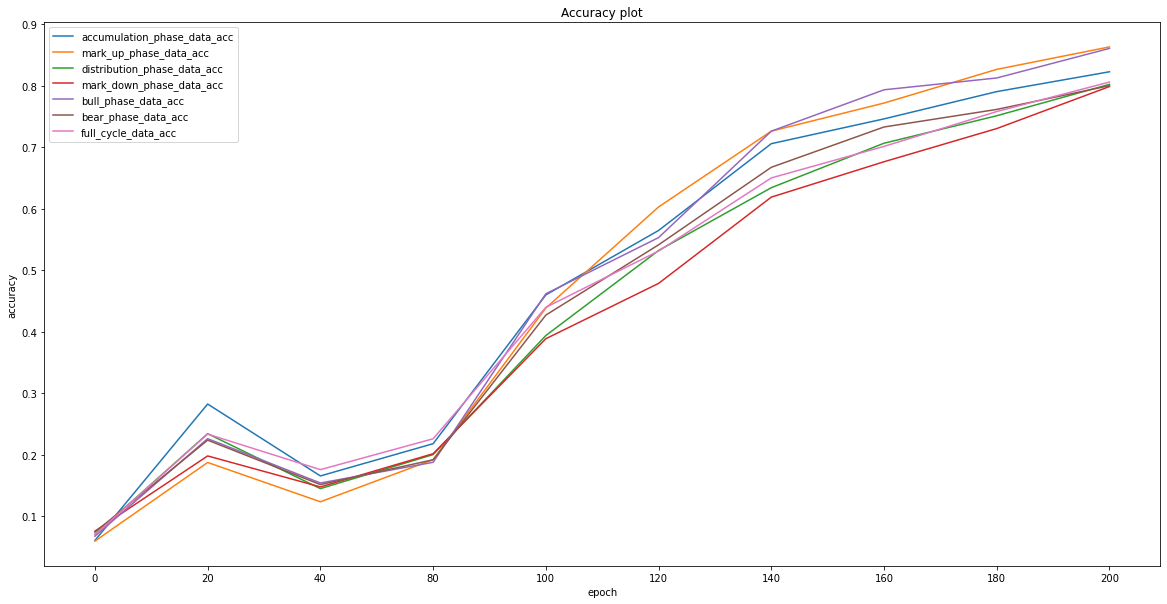

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
labels=[0,20,40,80,100,120,140,160,180,200]
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.plot(accumulation_phase_data_acc)
plt.plot(mark_up_phase_data_acc)
plt.plot(distribution_phase_data_acc)
plt.plot(mark_down_phase_data_acc)
plt.plot(bull_phase_data_acc)
plt.plot(bear_phase_data_acc)
plt.plot(full_cycle_data_acc)
plt.title('Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['accumulation_phase_data_acc','mark_up_phase_data_acc','distribution_phase_data_acc','mark_down_phase_data_acc','bull_phase_data_acc','bear_phase_data_acc','full_cycle_data_acc'], loc='upper left')
plt.show()

Text(0.5, 1.0, 'full_cycle_data_correct_buys')

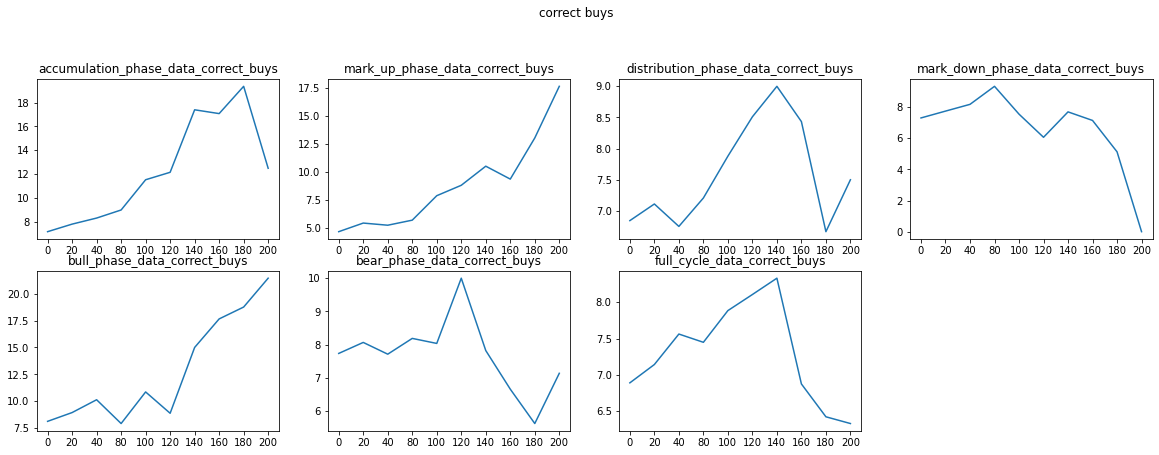

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("correct buys")

plt.subplot(3, 4, 1)
plt.plot(accumulation_phase_data_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("accumulation_phase_data_correct_buys")

plt.subplot(3, 4, 2)
plt.plot(mark_up_phase_data_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("mark_up_phase_data_correct_buys")

plt.subplot(3, 4, 3)
plt.plot(distribution_phase_data_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("distribution_phase_data_correct_buys")

plt.subplot(3, 4, 4)
plt.plot(mark_down_phase_data_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("mark_down_phase_data_correct_buys")

plt.subplot(3, 4, 5)
plt.plot(bull_phase_data_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("bull_phase_data_correct_buys")

plt.subplot(3, 4, 6)
plt.plot(bear_phase_data_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("bear_phase_data_correct_buys")

plt.subplot(3, 4, 7)
plt.plot(full_cycle_data_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("full_cycle_data_correct_buys")

Text(0.5, 1.0, 'full_cycle_data_correct_sells')

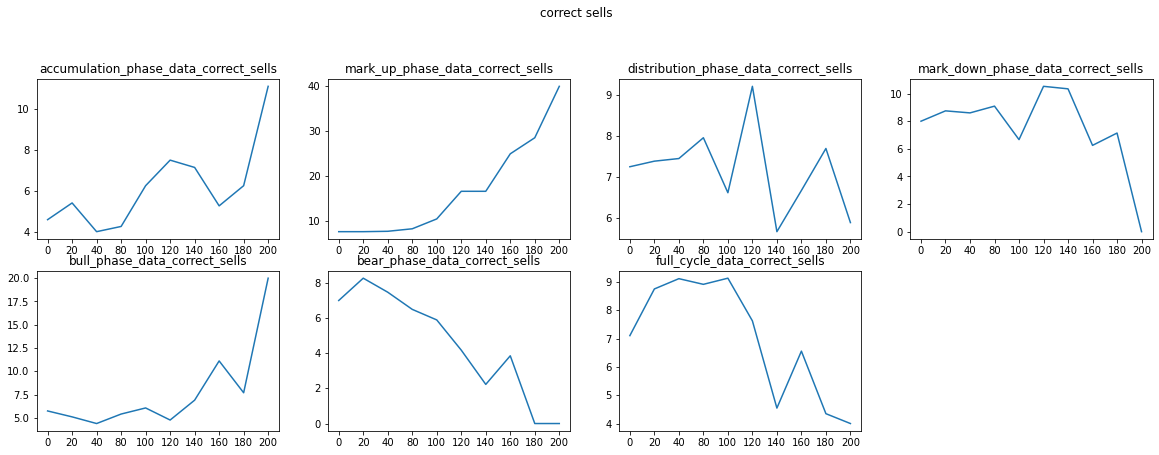

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("correct sells")

plt.subplot(3, 4, 1)
plt.plot(accumulation_phase_data_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("accumulation_phase_data_correct_sells")

plt.subplot(3, 4, 2)
plt.plot(mark_up_phase_data_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("mark_up_phase_data_correct_sells")

plt.subplot(3, 4, 3)
plt.plot(distribution_phase_data_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("distribution_phase_data_correct_sells")

plt.subplot(3, 4, 4)
plt.plot(mark_down_phase_data_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("mark_down_phase_data_correct_sells")

plt.subplot(3, 4, 5)
plt.plot(bull_phase_data_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("bull_phase_data_correct_sells")

plt.subplot(3, 4, 6)
plt.plot(bear_phase_data_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("bear_phase_data_correct_sells")

plt.subplot(3, 4, 7)
plt.plot(full_cycle_data_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("full_cycle_data_correct_sells")

Text(0.5, 1.0, 'full_cycle_data_correct_holds')

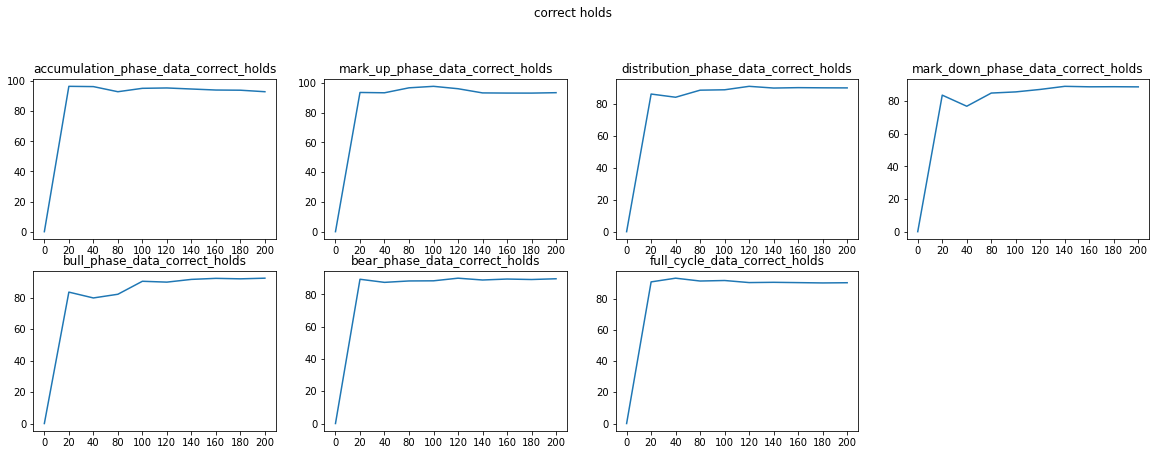

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("correct holds")

plt.subplot(3, 4, 1)
plt.plot(accumulation_phase_data_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("accumulation_phase_data_correct_holds")

plt.subplot(3, 4, 2)
plt.plot(mark_up_phase_data_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("mark_up_phase_data_correct_holds")

plt.subplot(3, 4, 3)
plt.plot(distribution_phase_data_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("distribution_phase_data_correct_holds")

plt.subplot(3, 4, 4)
plt.plot(mark_down_phase_data_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("mark_down_phase_data_correct_holds")

plt.subplot(3, 4, 5)
plt.plot(bull_phase_data_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("bull_phase_data_correct_holds")

plt.subplot(3, 4, 6)
plt.plot(bear_phase_data_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("bear_phase_data_correct_holds")

plt.subplot(3, 4, 7)
plt.plot(full_cycle_data_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("full_cycle_data_correct_holds")

Text(0.5, 1.0, 'full_cycle_data_correct_low_buys')

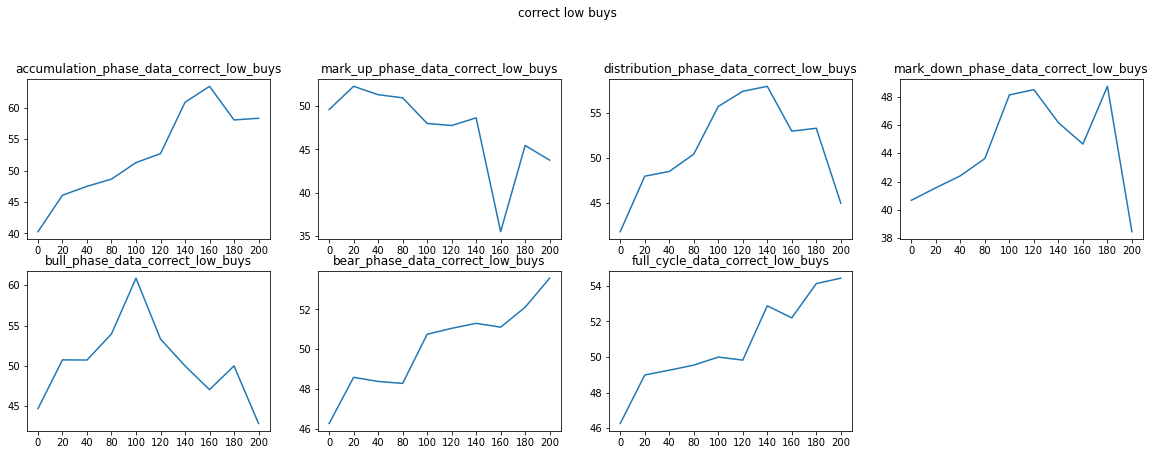

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("correct low buys")

plt.subplot(3, 4, 1)
plt.plot(accumulation_phase_data_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("accumulation_phase_data_correct_low_buys")

plt.subplot(3, 4, 2)
plt.plot(mark_up_phase_data_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("mark_up_phase_data_correct_low_buys")

plt.subplot(3, 4, 3)
plt.plot(distribution_phase_data_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("distribution_phase_data_correct_low_buys")

plt.subplot(3, 4, 4)
plt.plot(mark_down_phase_data_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("mark_down_phase_data_correct_low_buys")

plt.subplot(3, 4, 5)
plt.plot(bull_phase_data_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("bull_phase_data_correct_low_buys")

plt.subplot(3, 4, 6)
plt.plot(bear_phase_data_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("bear_phase_data_correct_low_buys")

plt.subplot(3, 4, 7)
plt.plot(full_cycle_data_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("full_cycle_data_correct_low_buys")

Text(0.5, 1.0, 'full_cycle_data_correct_high_sells')

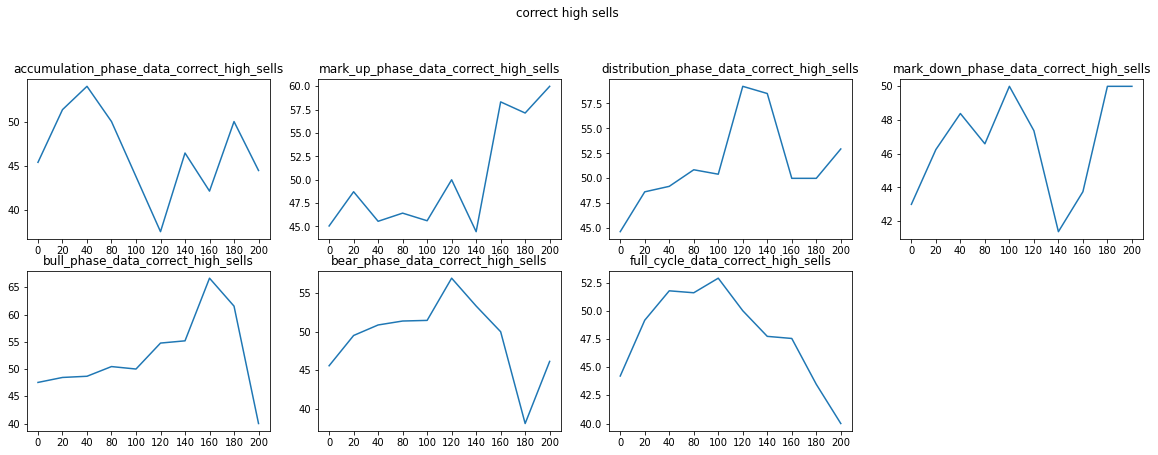

In [28]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("correct high sells")

plt.subplot(3, 4, 1)
plt.plot(accumulation_phase_data_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("accumulation_phase_data_correct_high_sells")

plt.subplot(3, 4, 2)
plt.plot(mark_up_phase_data_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("mark_up_phase_data_correct_high_sells")

plt.subplot(3, 4, 3)
plt.plot(distribution_phase_data_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("distribution_phase_data_correct_high_sells")

plt.subplot(3, 4, 4)
plt.plot(mark_down_phase_data_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("mark_down_phase_data_correct_high_sells")

plt.subplot(3, 4, 5)
plt.plot(bull_phase_data_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("bull_phase_data_correct_high_sells")

plt.subplot(3, 4, 6)
plt.plot(bear_phase_data_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("bear_phase_data_correct_high_sells")

plt.subplot(3, 4, 7)
plt.plot(full_cycle_data_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("full_cycle_data_correct_high_sells")

Text(0.5, 1.0, 'full_cycle_data_correct_mid_holds')

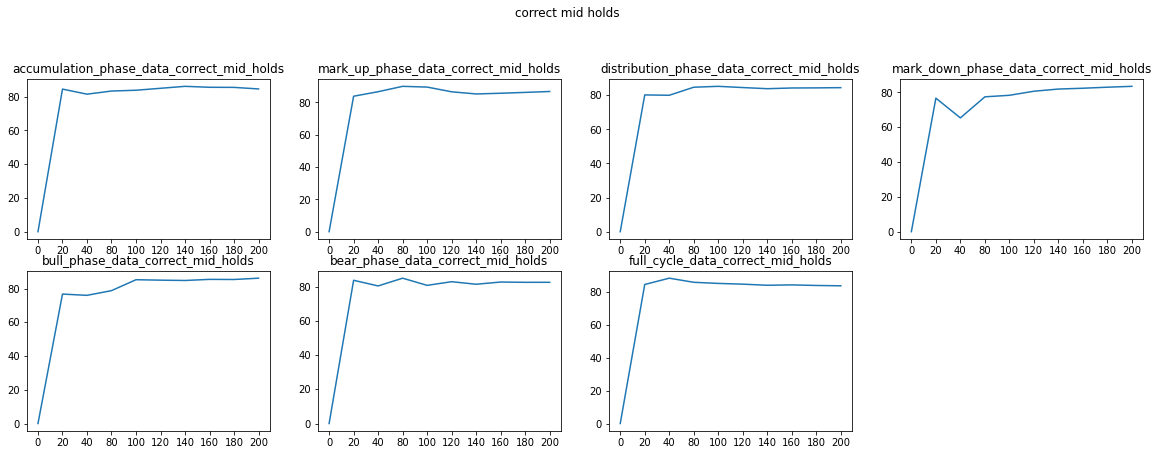

In [29]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("correct mid holds")

plt.subplot(3, 4, 1)
plt.plot(accumulation_phase_data_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("accumulation_phase_data_correct_mid_holds")

plt.subplot(3, 4, 2)
plt.plot(mark_up_phase_data_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("mark_up_phase_data_correct_mid_holds")

plt.subplot(3, 4, 3)
plt.plot(distribution_phase_data_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("distribution_phase_data_correct_mid_holds")

plt.subplot(3, 4, 4)
plt.plot(mark_down_phase_data_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("mark_down_phase_data_correct_mid_holds")

plt.subplot(3, 4, 5)
plt.plot(bull_phase_data_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("bull_phase_data_correct_mid_holds")

plt.subplot(3, 4, 6)
plt.plot(bear_phase_data_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("bear_phase_data_correct_mid_holds")

plt.subplot(3, 4, 7)
plt.plot(full_cycle_data_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("full_cycle_data_correct_mid_holds")

Text(0.5, 1.0, 'full_cycle_data_profit')

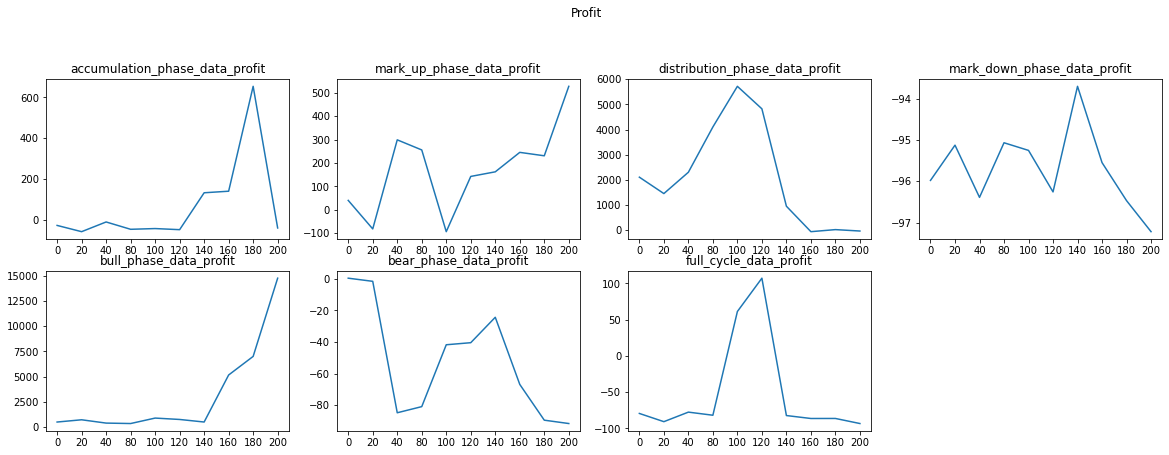

In [30]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Profit")

plt.subplot(3, 4, 1)
plt.plot(accumulation_phase_data_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("accumulation_phase_data_profit")

plt.subplot(3, 4, 2)
plt.plot(mark_up_phase_data_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("mark_up_phase_data_profit")

plt.subplot(3, 4, 3)
plt.plot(distribution_phase_data_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("distribution_phase_data_profit")

plt.subplot(3, 4, 4)
plt.plot(mark_down_phase_data_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("mark_down_phase_data_profit")

plt.subplot(3, 4, 5)
plt.plot(bull_phase_data_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("bull_phase_data_profit")

plt.subplot(3, 4, 6)
plt.plot(bear_phase_data_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("bear_phase_data_profit")

plt.subplot(3, 4, 7)
plt.plot(full_cycle_data_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("full_cycle_data_profit")